<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S11/EVA_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')

In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np
import cv2
means = (0.49139968, 0.48215841, 0.44653091)
stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transforms = AlbumentationTransforms(
    [ A.PadIfNeeded(40,40,border_mode=cv2.BORDER_CONSTANT, value=np.array(means)*255),
      A.RandomCrop(32, 32,  always_apply=True),
      A.HorizontalFlip(),
      A.Normalize(mean=means, std=stdevs),
      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=1)])




test_transforms = AlbumentationTransforms([A.Normalize(mean=means, std=stdevs)])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(trainset)
testloader = dataloader.load(testset)

Let us show some of the training images, for fun.



torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


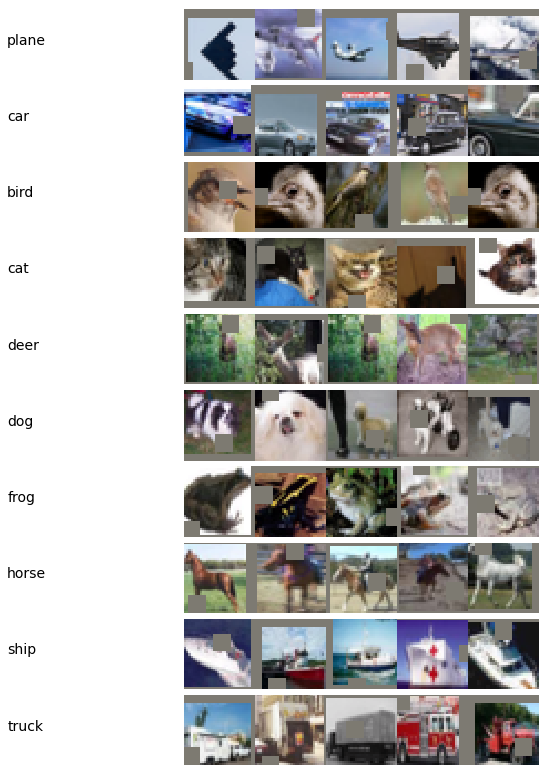

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*stdevs[i])+means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
 

r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, classes[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
import evamodel

net = evamodel.newResnet()

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


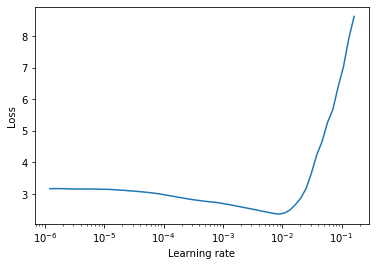

In [10]:
import sys
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")
# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [11]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
max_lr = lr[loss.index(min(loss))]
max_lr

0.008912509381337464

In [12]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test
from torch.optim.lr_scheduler import OneCycleLR
L1lambda = 0
L2lambda = 0
EPOCHS = 24
model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.03,
                 total_steps=25,
                 epochs=25,
                 pct_start=0.2,
                 cycle_momentum=False,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=10.,
                 final_div_factor=1e4,
                 last_epoch=-1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    scheduler.step()
    test(model, device, testloader)


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.2151366472244263 Batch_id=97 Accuracy=48.42: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4028, Accuracy: 5972/10000 (59.72%)

EPOCH: 1


Loss=0.9685332775115967 Batch_id=97 Accuracy=58.32: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3755, Accuracy: 6245/10000 (62.45%)

EPOCH: 2


Loss=1.192735195159912 Batch_id=97 Accuracy=48.13: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3919, Accuracy: 6081/10000 (60.81%)

EPOCH: 3


Loss=1.0793477296829224 Batch_id=97 Accuracy=60.75: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3036, Accuracy: 6964/10000 (69.64%)

EPOCH: 4


Loss=0.5978615880012512 Batch_id=97 Accuracy=70.41: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2442, Accuracy: 7558/10000 (75.58%)

EPOCH: 5


Loss=0.620051383972168 Batch_id=97 Accuracy=76.17: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2146, Accuracy: 7854/10000 (78.54%)

EPOCH: 6


Loss=0.815782904624939 Batch_id=97 Accuracy=79.66: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2082, Accuracy: 7918/10000 (79.18%)

EPOCH: 7


Loss=0.6179817914962769 Batch_id=97 Accuracy=82.22: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1819, Accuracy: 8181/10000 (81.81%)

EPOCH: 8


Loss=0.47276628017425537 Batch_id=97 Accuracy=84.03: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1610, Accuracy: 8390/10000 (83.90%)

EPOCH: 9


Loss=0.5103754997253418 Batch_id=97 Accuracy=86.29: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1731, Accuracy: 8269/10000 (82.69%)

EPOCH: 10


Loss=0.409525066614151 Batch_id=97 Accuracy=87.69: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1405, Accuracy: 8595/10000 (85.95%)

EPOCH: 11


Loss=0.3612307012081146 Batch_id=97 Accuracy=88.68: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1354, Accuracy: 8646/10000 (86.46%)

EPOCH: 12


Loss=0.23045869171619415 Batch_id=97 Accuracy=90.09: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1200, Accuracy: 8800/10000 (88.00%)

EPOCH: 13


Loss=0.27238157391548157 Batch_id=97 Accuracy=91.18: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1210, Accuracy: 8790/10000 (87.90%)

EPOCH: 14


Loss=0.2467281073331833 Batch_id=97 Accuracy=92.23: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1153, Accuracy: 8847/10000 (88.47%)

EPOCH: 15


Loss=0.24563194811344147 Batch_id=97 Accuracy=92.85: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1096, Accuracy: 8904/10000 (89.04%)

EPOCH: 16


Loss=0.2512713074684143 Batch_id=97 Accuracy=93.78: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 8913/10000 (89.13%)

EPOCH: 17


Loss=0.13968226313591003 Batch_id=97 Accuracy=94.37: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1070, Accuracy: 8930/10000 (89.30%)

EPOCH: 18


Loss=0.11784044653177261 Batch_id=97 Accuracy=94.92: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1007, Accuracy: 8993/10000 (89.93%)

EPOCH: 19


Loss=0.16320034861564636 Batch_id=97 Accuracy=95.42: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.1003, Accuracy: 8997/10000 (89.97%)

EPOCH: 20


Loss=0.10909215360879898 Batch_id=97 Accuracy=95.91: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0977, Accuracy: 9023/10000 (90.23%)

EPOCH: 21


Loss=0.12008549273014069 Batch_id=97 Accuracy=96.13: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0970, Accuracy: 9030/10000 (90.30%)

EPOCH: 22


Loss=0.0815490335226059 Batch_id=97 Accuracy=96.49: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0959, Accuracy: 9041/10000 (90.41%)

EPOCH: 23


Loss=0.09854177385568619 Batch_id=97 Accuracy=96.52: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.0950, Accuracy: 9050/10000 (90.50%)



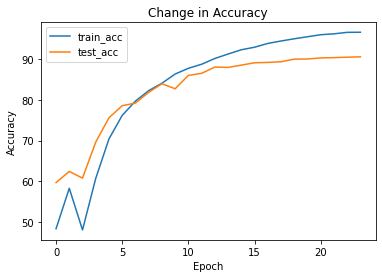

In [13]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

25


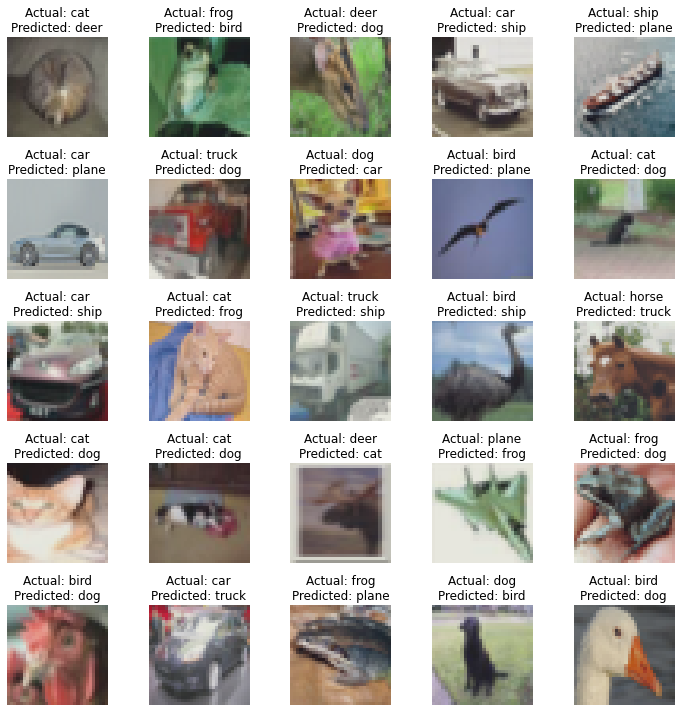

In [15]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

In [0]:
model_save_name = 'models11.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [17]:
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

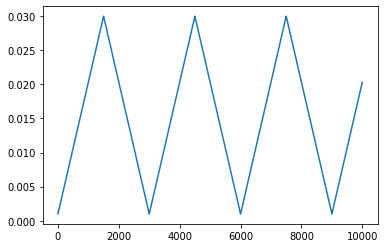

In [18]:
from utils import print_triangular_lr
num_iterations = 10000
stepsize = 1500
base_lr = 0.001
max_lr = 0.03
lr_trend = list()

for iteration in range(num_iterations):
    lr = print_triangular_lr(iteration, stepsize, base_lr, max_lr)
    lr_trend.append(lr)

plt.plot(lr_trend)